<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Ifpe_logomarca.png/1200px-Ifpe_logomarca.png" alt="IFPE Logo" width="300">

***Campus* Garanhuns**

# Rede neural numérica geral
Por *Gabriel Carvalho*

Neste notebook, é desenvolvido uma rede neural para identificação dos caracteres numéricos [0-9] , em diferenciação dos caracteres do alfabeto [A-Z], nos modelos de placas do mercosul e nos modelos antigos

## Arquitetura do Modelo
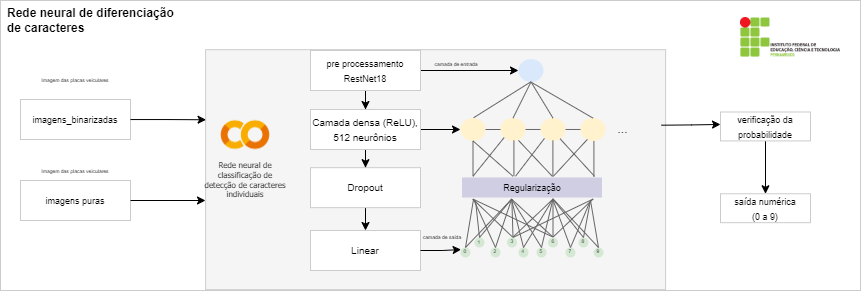)

## Importações

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import zipfile
import random

## Operações iniciais dos arquivos

In [ ]:
# mover o arquivo .zip
!cp /content/drive/MyDrive/dataset-placas-main.zip .

In [4]:
# extração do dataset
with zipfile.ZipFile('/content/dataset-placas-main.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [22]:
!cp -r /content/dataset-placas-main/recortes/ .

In [23]:
!cp -r /content/dataset-placas-main/recortes_segmentacao_binarizada/ .

In [25]:
!cp -r /content/dataset-placas-main/recortes_min7_segmentacao_binarizada/ .

In [5]:
!cp /content/dataset-placas-main/output_recortes.json .

In [6]:
!cp /content/dataset-placas-main/output_recortes_segmentacao_binarizada.json .

## Carregar e transformar os arquivos de recortes gerais

In [13]:
# ler o arquivo de recortes das imagens normais
with open("/content/output_recortes.json", "r") as f:
    data = json.load(f)

In [16]:
# separar o datase em outro dataset, de apenas números 0-9
numeros_data = {}

numeros_validos = {str(i) for i in range(10)}

for key, values in data.items():
    numeros_filtrados = [
        item for item in values
        if item["char"] in numeros_validos
        and "_min_7" not in item["imagem"]
    ]
    if numeros_filtrados:
        numeros_data[key] = numeros_filtrados

with open("output_numeros_normais.json", "w") as f:
    json.dump(numeros_data, f, indent=4)

print("Novo dataset contendo apenas números salvo como 'output_numeros_normais.json'")

Novo dataset contendo apenas números salvo como 'output_numeros_normais.json'


## Carregar e transformar os arquivos de recortes de binarização

In [35]:
# ler o arquivo de recortes das imagens binarizadas
with open("/content/output_recortes_segmentacao_binarizada.json", "r") as f:
    data_segmentacao = json.load(f)

In [36]:
# separar o datase em outro dataset, de apenas números 0-9
numeros_data = {}

numeros_validos = {str(i) for i in range(10)}

for key, values in data_segmentacao.items():
    numeros_filtrados = [
        item for item in values
        if item["char"] in numeros_validos
        and "_min_7" not in item["imagem"]
    ]
    if numeros_filtrados:
        numeros_data[key] = numeros_filtrados

with open("output_numeros_segmentacao.json", "w") as f:
    json.dump(numeros_data, f, indent=4)

print("Novo dataset contendo apenas números salvo como 'output_numeros_segmentacao.json'")

Novo dataset contendo apenas números salvo como 'output_numeros_segmentacao.json'


## Concatenação dos arquivos

In [37]:
# concatenar os dois arquivos
with open("/content/output_numeros_normais.json", "r", encoding="utf-8") as f1, open("/content/output_numeros_segmentacao.json", "r", encoding="utf-8") as f2:
    json1 = json.load(f1)
    json2 = json.load(f2)

# Mesclar os dicionários
for key, value in json2.items():
    if key in json1:
        json1[key].extend(value)  # Se a chave já existe, adiciona os itens
    else:
        json1[key] = value  # Se a chave não existe, adiciona diretamente

# Salvar o JSON final
with open("output_numeros.json", "w", encoding="utf-8") as f_out:
    json.dump(json1, f_out, ensure_ascii=False, indent=4)

print("Arquivos mesclados com sucesso!")

Arquivos mesclados com sucesso!


In [38]:
with open("output_numeros.json", "r") as f:
    num_data = json.load(f)

## Definições gerais da rede neural

In [39]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [40]:
class DatasetNumerico(Dataset):
    def __init__(self, data, transform=None):
        self.data = []
        self.transform = transform
        for key, values in data.items():
            for item in values:
                img_path = item["imagem"]
                label = int(item["char"])
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        # Verifica se o arquivo existe antes de abrir
        if not os.path.exists(img_path):
            print(f"AVISO: Imagem não encontrada: {img_path}. Pulando...")
            # Escolher outra amostra aleatoriamente para substituir a ausente
            return self.__getitem__(random.randint(0, len(self.data) - 1))

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Erro ao abrir {img_path}: {e}")
            return self.__getitem__(random.randint(0, len(self.data) - 1))  # Evita erro retornando outro dado


In [41]:
dataset = DatasetNumerico(num_data, transform=transform_train)

## Divisão da base de dados para treinamento e validação

In [42]:
# dividindo o dataset em 80% para treinamento e 20% para validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [43]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Treinar a rede neural

In [44]:
def treinar_resnet18(train_loader, val_loader, num_epochs=30, learning_rate=1e-4, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Carregar a ResNet18 pré-treinada
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    # Ajustar a camada final com ReLU e Dropout
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 10)
    )
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    best_acc = 0.0
    print(f"Iniciando treinamento por {num_epochs} épocas...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        print(f"Época [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f} - Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "melhor_modelo_resnet18.pth")
            print("Melhor modelo salvo!")
    print("Treinamento concluído!")
    return model

In [ ]:
modelo_treinado = treinar_resnet18(train_loader, val_loader, num_epochs=24, learning_rate=0.005)

## Calcular inferência

In [ ]:
transform_inference = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Realizar predições com o modelo treinado

In [ ]:
def prever_caractere(image_path, model, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = Image.open(image_path).convert("RGB")
    image = transform_inference(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [ ]:
def carregar_modelo(model_path="melhor_modelo_resnet18.pth", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 10)
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [ ]:
!cp /content/recortes/placa_218_0/4_3.png .

In [ ]:
modelo = carregar_modelo("melhor_modelo_resnet18.pth")

imagens_teste = {
    "exemplo.png": "4",
    "exemplo.png": "4",
    "exemplo.png": "4",
    "exemplo.png": "4",
    "exemplo.png": "4",
    "exemplo.png": "4",
    "exemplo.png": "4",
}

for img_path, valor in imagens_teste.items():
    resultado = prever_caractere(img_path, modelo)
    print(f"Imagem: {img_path}\n-> Caractere previsto: {resultado} | Esperado: {valor} | {'Certo' if str(resultado) == valor else 'Errado'}")